## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Configs

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

## UDFs

In [3]:
def count_plot(x, dataframe, ax=None, **kwargs):
    if len(kwargs)==1 and kwargs['mode']=='horizontal':
        sns.countplot(y=x, data=dataframe, ax=ax, order=dataframe[x].value_counts().index)
    else:
        sns.countplot(x=x, data=dataframe, ax=ax, order=dataframe[x].value_counts().index)
    plt.box(False)
    return None

    
def pie_plot(df_col, fig_size, title):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.pie(df_col.values, autopct='%1.2f%%', shadow=False, startangle=90)
    ax.axis('equal')
    plt.legend(labels=df_col.index, bbox_to_anchor=(1.05, 1))
    plt.title(title)
    plt.show()
    return None


def stacked_vBar_plot(dataframe, value, index, column, xlabel, fig_size, scale='linear', with_percent=True):
    
    df_1 = dataframe.pivot_table(values=[value], index=[index], columns=[column], aggfunc=len, margins=True)
    df_1_percent = df_1.div(df_1.iloc[:,-1], axis=0).mul(100, axis=0).round(2)
    df_2_percent = df_1_percent.iloc[:, :-1].drop('All')
    
    columns = df_2_percent.columns.levels[1].tolist()
    columns.remove('All')
    
    ax = df_2_percent.plot.bar(stacked=True)
    ax.figure.set_size_inches(fig_size)
    ax.grid(False)
    plt.legend(labels=columns, bbox_to_anchor=(1.05, 1), title='NPS Type')
    plt.xlabel(xlabel)
    plt.ylabel('%GT Count of NPS_Type')
    
    if with_percent:
        # Add this loop to add the annotations
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.2f}%'.format(height), (x + width/8, y + height/2))
    plt.box(False)
    plt.show()
    return None


def pdf_distribution_plots(df, features, target):
    nrow = int((len(features)/3) + len(features)%3)
    
    t0 = df.loc[df[target] == 0]
    t1 = df.loc[df[target] == 1]

    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15,10))

    for indx, feature in enumerate(features):
        ax = fig.add_subplot(nrow, 3, indx+1)
        sns.kdeplot(t0[feature], label="0", legend=True)
        sns.kdeplot(t1[feature], label="1", legend=True)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.legend(loc='best')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace= 0.3, hspace=0.5)
    plt.show()
    return None


def clipping(dataframe, num_cols):
    df_copy = dataframe.copy()
    for col in num_cols:
        p25 = np.percentile(df_copy[col], 25)
        p75 = np.percentile(df_copy[col], 75)
        iqr = p75 - p25
        df_copy[col] = np.clip(df_copy[col], a_min=np.floor((p25 - 1.5*iqr)), a_max=np.ceil((p75 + 1.5*iqr)))
    return df_copy


def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = col + '_CAT'
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

## Load Datasets

In [4]:
dir_path = '/kaggle/input/h-and-m-personalized-fashion-recommendations/'

artcls_df = pd.read_csv(dir_path + 'articles.csv')
cust_df = pd.read_csv(dir_path + 'customers.csv')
trnsctns_df = pd.read_csv(dir_path + 'transactions_train.csv')

In [5]:
artcls_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [6]:
cust_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [7]:
trnsctns_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


## Basic Statistics

### Articles

In [8]:
artcls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64


<Axes: >

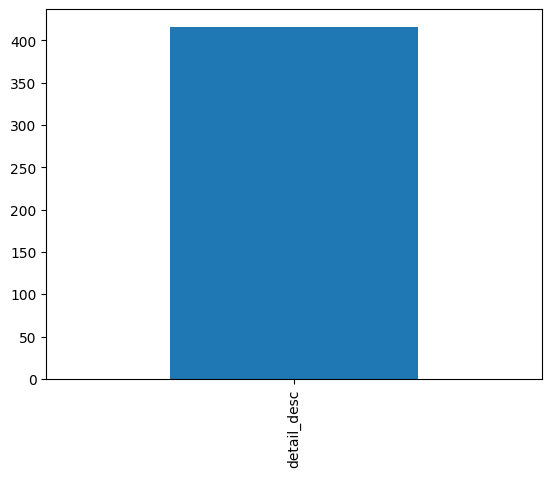

In [9]:
# Missing Data - Articles
print(artcls_df.isna().sum())
artcls_df.isna().sum()[artcls_df.isna().sum()>0].plot(kind='bar')

### Customers

In [10]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64


<Axes: >

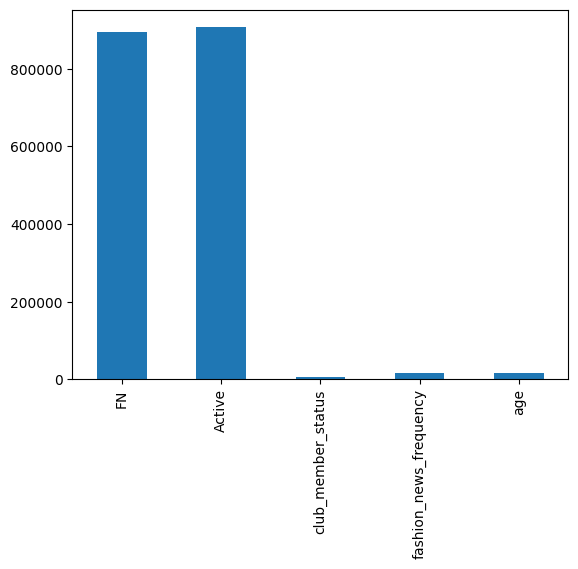

In [11]:
# Missing Data - Customers
print(cust_df.isna().sum())
cust_df.isna().sum()[cust_df.isna().sum()>0].plot(kind='bar')

In [12]:
cust_df.describe(exclude=['object']).applymap('{:,.4f}'.format)

,FN,Active,age
count,"476,930.0000","464,404.0000","1,356,119.0000"
mean,1.0000,1.0000,36.3870
std,0.0000,0.0000,14.3136
min,1.0000,1.0000,16.0000
25%,1.0000,1.0000,24.0000
50%,1.0000,1.0000,32.0000
75%,1.0000,1.0000,49.0000
max,1.0000,1.0000,99.0000


### Transactions

In [13]:
trnsctns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [14]:
trnsctns_df.isna().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [15]:
trnsctns_df.drop(columns=['customer_id', 'article_id', 'sales_channel_id']).describe(exclude=['object']).applymap('{:,.4f}'.format)

,price
count,"31,788,324.0000"
mean,0.0278
std,0.0192
min,0.0000
25%,0.0158
50%,0.0254
75%,0.0339
max,0.5915


In [16]:
trnsctns_df['sales_channel_id'].astype('object').describe()

count     31788324
unique           2
top              2
freq      22379862
Name: sales_channel_id, dtype: int64

## Data Pre-processing

### Handle missing values

In [19]:
cust_df['FN'] = cust_df['FN'].fillna(0)
cust_df['Active'] = cust_df['Active'].fillna(0)
cust_df['club_member_status'] = cust_df['club_member_status'].fillna('NOT A MEMBER')
cust_df['Active'] = cust_df['Active'].fillna('NONE')
cust_df['age'] = cust_df['age'].fillna(cust_df['age'].median())

## Data Preparation

In [20]:
mergd_df = trnsctns_df.merge(artcls_df.drop(columns=['detail_desc']), on='article_id', how='left')
mergd_df = mergd_df.merge(cust_df.drop(columns=['postal_code']), on='customer_id', how='left')

mergd_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,FN,Active,club_member_status,fashion_news_frequency,age
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1338,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",0.0,0.0,ACTIVE,NONE,24.0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,1010016,Solid,51,Light Pink,1,Dusty Light,4,Pink,1334,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",0.0,0.0,ACTIVE,NONE,24.0
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,505221,Inca Jumper,252,Sweater,Garment Upper body,1010010,Melange,52,Pink,2,Medium Dusty,4,Pink,5963,Tops Knitwear DS,D,Divided,2,Divided,58,Divided Selected,1003,Knitwear,1.0,1.0,ACTIVE,Regularly,32.0
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,1010010,Melange,52,Pink,7,Medium,4,Pink,3090,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,1.0,1.0,ACTIVE,Regularly,32.0
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,1010010,Melange,93,Dark Green,4,Dark,19,Green,3090,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,1.0,1.0,ACTIVE,Regularly,32.0


## Univariate Analysis - Customer Demographics Data

* 65% of the customers have FN=0

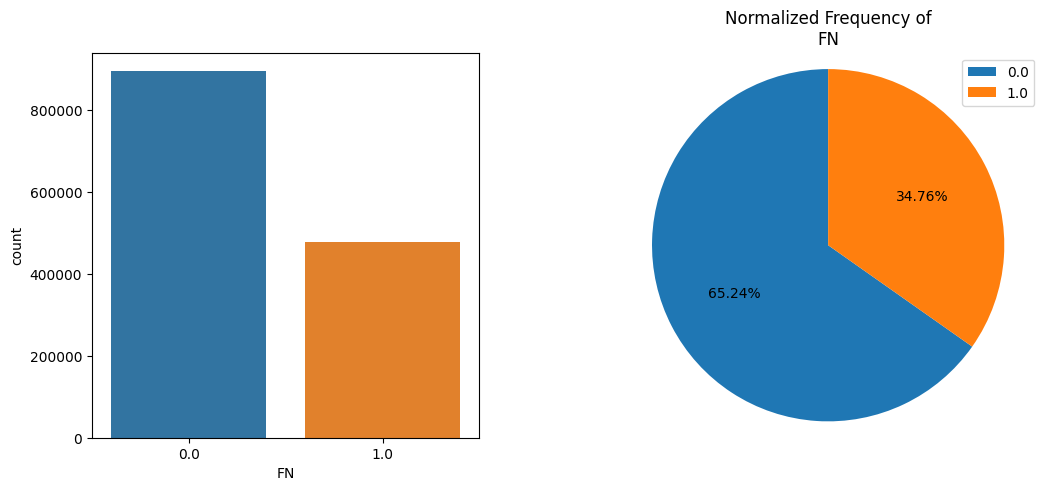

In [21]:
feature = 'FN'
unique_id = 'customer_id'

fig1, axes1 = plt.subplots(1, 2, figsize=(12,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=cust_df, ax=axes1[0])

grouped_df = cust_df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

* Nearly 34% of the cutomers are in Active state

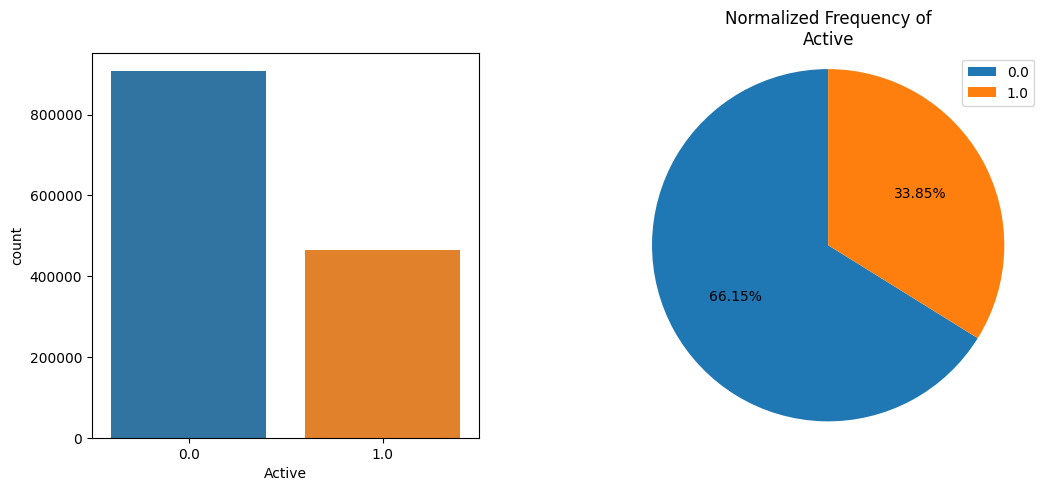

In [22]:
feature = 'Active'
unique_id = 'customer_id'

fig1, axes1 = plt.subplots(1, 2, figsize=(12,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=cust_df, ax=axes1[0])

grouped_df = cust_df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

* 93% of the customers are in Active state.

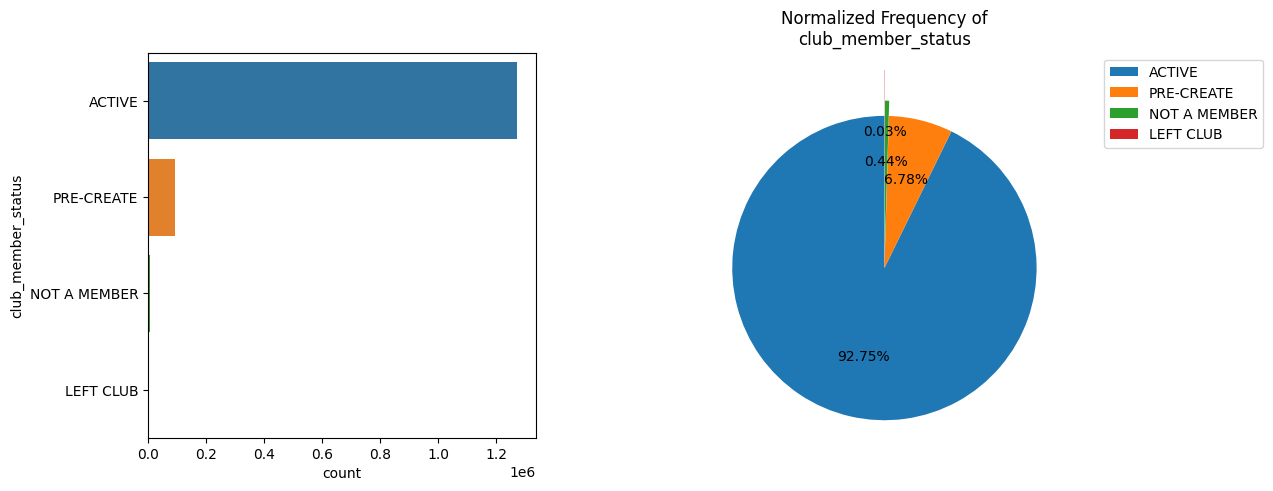

In [28]:
feature = 'club_member_status'
unique_id = 'customer_id'

fig1, axes1 = plt.subplots(1, 2, figsize=(12,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=cust_df, ax=axes1[0], mode='horizontal')

grouped_df = cust_df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0, 0.1, 0.3))
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

* 35% of the customers regularly receives fashion news.

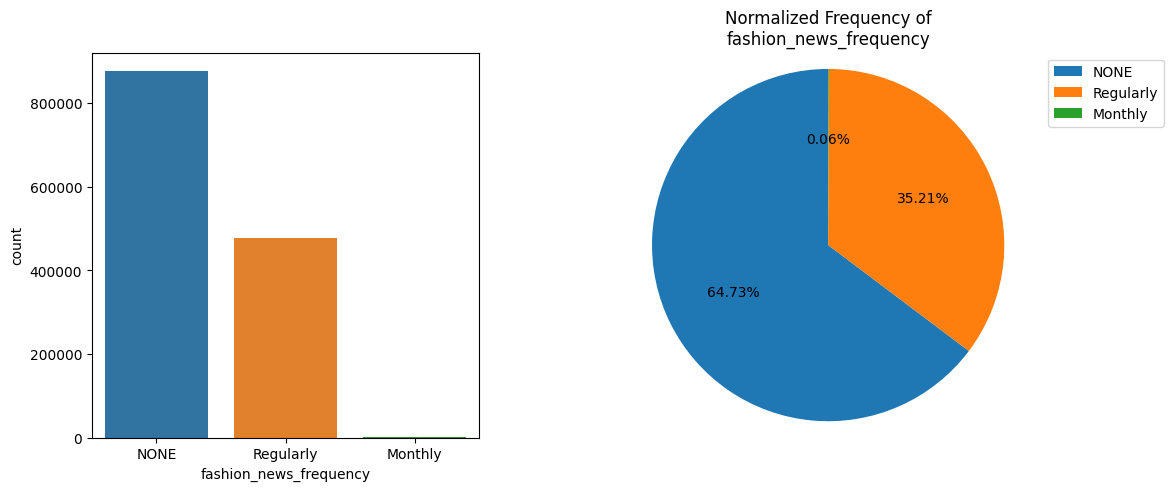

In [29]:
feature = 'fashion_news_frequency'
unique_id = 'customer_id'

fig1, axes1 = plt.subplots(1, 2, figsize=(12,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=cust_df, ax=axes1[0])

grouped_df = cust_df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

* 120303 customers have the same postal code, surprisingly

In [22]:
data_postal = cust_df.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
data_postal.head()

,postal_code,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
61034,2c29ae653a9282cce4151bd87643c907644e09541abc28...,120303,42874,39886,118281,114377,118002
281937,cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac...,261,109,104,261,261,260
156090,714976379549eb90aae4a71bca6c7402cc646ae7c40f6c...,159,90,88,159,159,158
171208,7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5...,157,55,54,157,156,156
126228,5b7eb31eabebd3277de632b82267286d847fd5d44287ee...,156,42,41,156,156,155


* Majority of the customers belong to age group 21-30

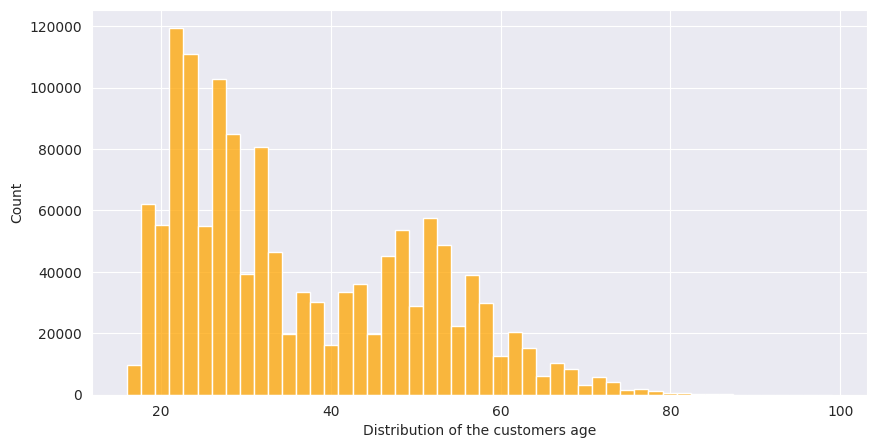

In [30]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=cust_df, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

## Univariate Analysis - Transactions Data

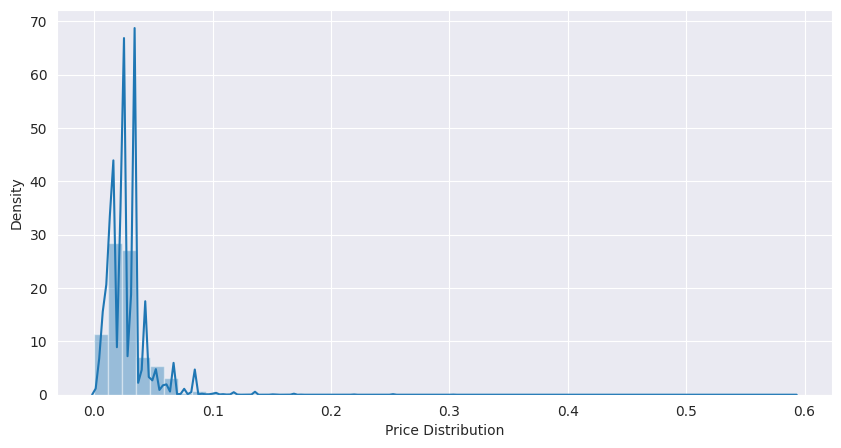

In [32]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.distplot(trnsctns_df['price'])
ax.set_xlabel('Price Distribution')
plt.show()

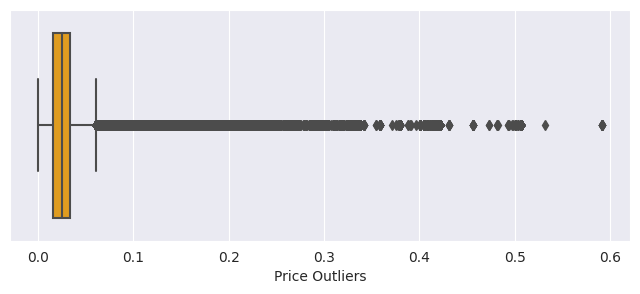

In [33]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(8,3))
ax = sns.boxplot(data=trnsctns_df, x='price', color='orange')
ax.set_xlabel('Price Outliers')
plt.show()

* Top 10 customers with highest no of transactions

In [34]:
transactions_byid = trnsctns_df.groupby('customer_id').count()

transactions_byid.sort_values(by='price', ascending=False)['price'][:10]

customer_id
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
55d15396193dfd45836af3a6269a079efea339e875eff42cc0c228b002548a9d    1208
c140410d72a41ee5e2e3ba3d7f5a860f337f1b5e41c27cf9bda5517c8774f8fa    1170
8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d659fa4e5c3af6cc076    1169
03d0011487606c37c1b1ed147fc72f285a50c05f00b9712e0fc3da400c864296    1157
6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2e57161f0ef810a4b55    1143
Name: price, dtype: int64

## Bivariate Analysis - Merged Data

Following product groups have a higher number of outliers, compared to other categories.

* Garment (Upper|Lower|Full) body
* Accessories
* Shoes

Therefore, has a large variance in price.

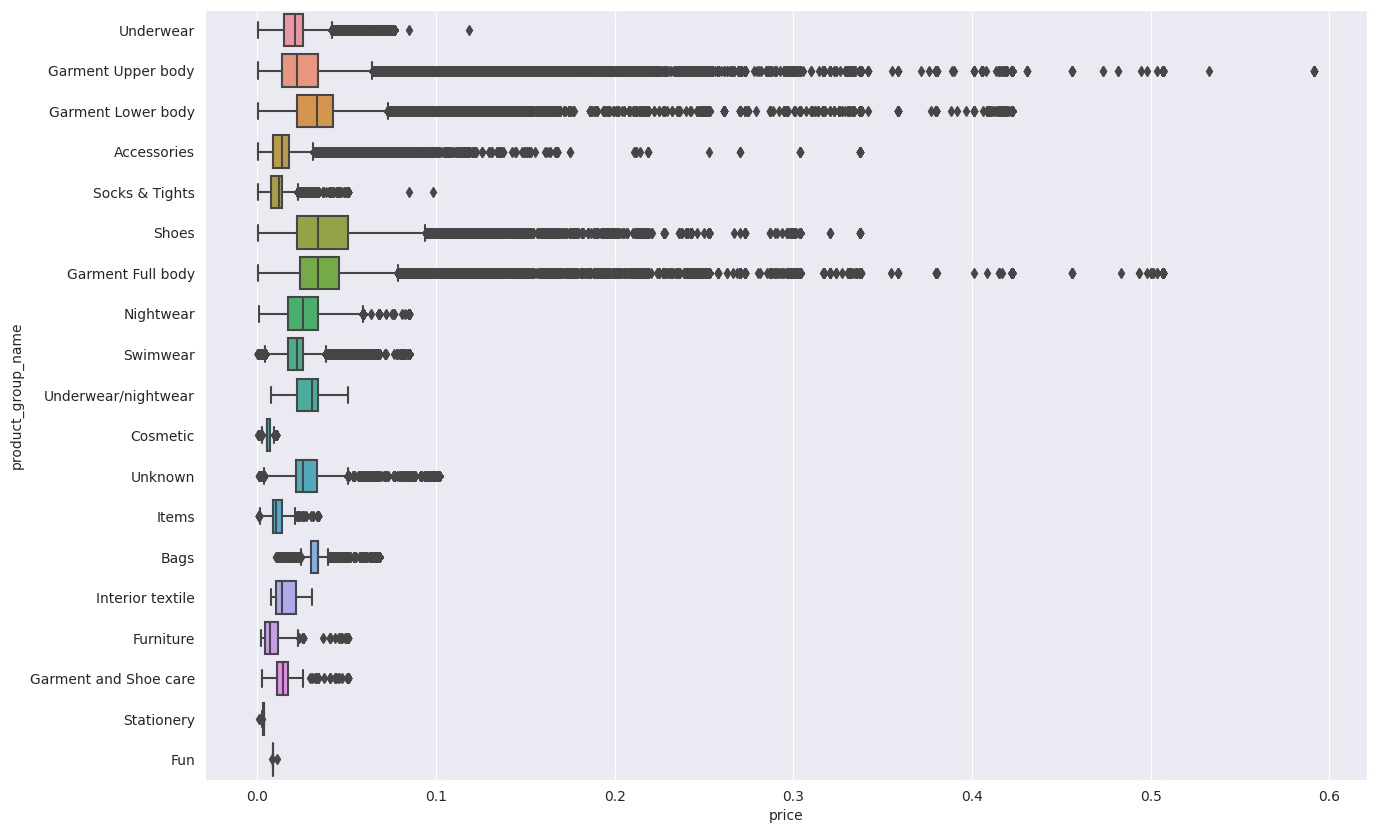

In [35]:
x = 'price'
y = 'product_group_name'

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(data=mergd_df, x=x, y=y)
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

* Active customers have a large price variance compared to other customers, which is expected.

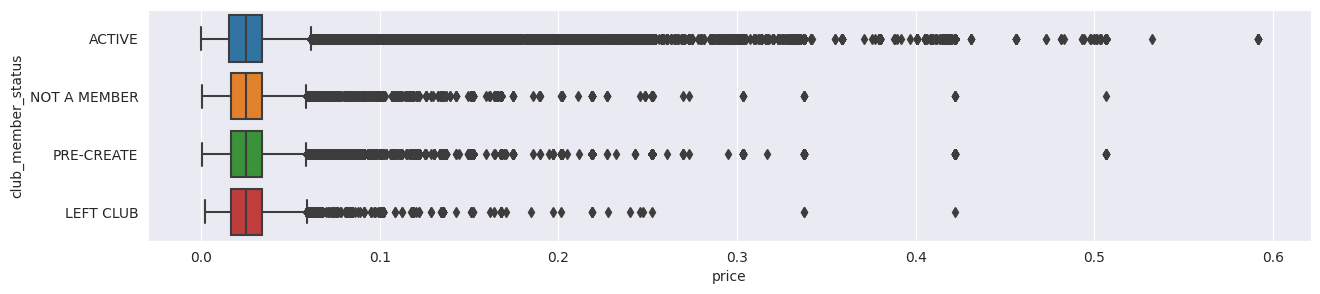

In [37]:
x = 'price'
y = 'club_member_status'

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15,3))
ax = sns.boxplot(data=mergd_df, x=x, y=y)
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

* Those who regularly receives the fashion news, actively engages with the store. Hence, they may buy wide range of products from the store than those who receive monthly updates.

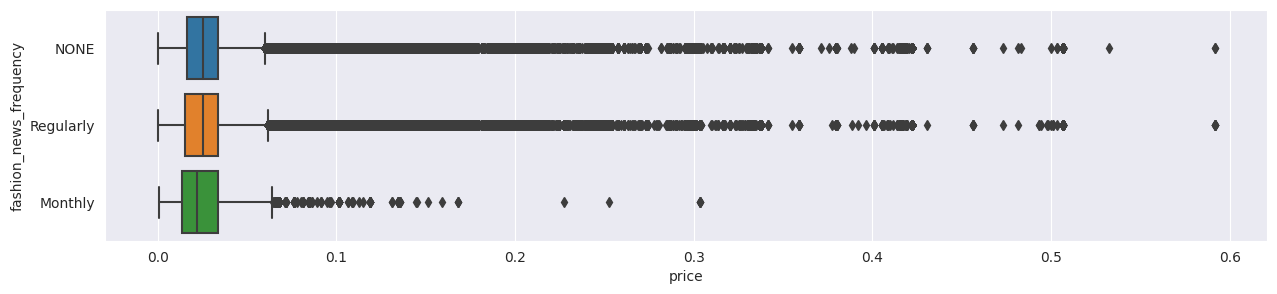

In [36]:
x = 'price'
y = 'fashion_news_frequency'

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15,3))
ax = sns.boxplot(data=mergd_df, x=x, y=y)
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

* Mean price of product groups

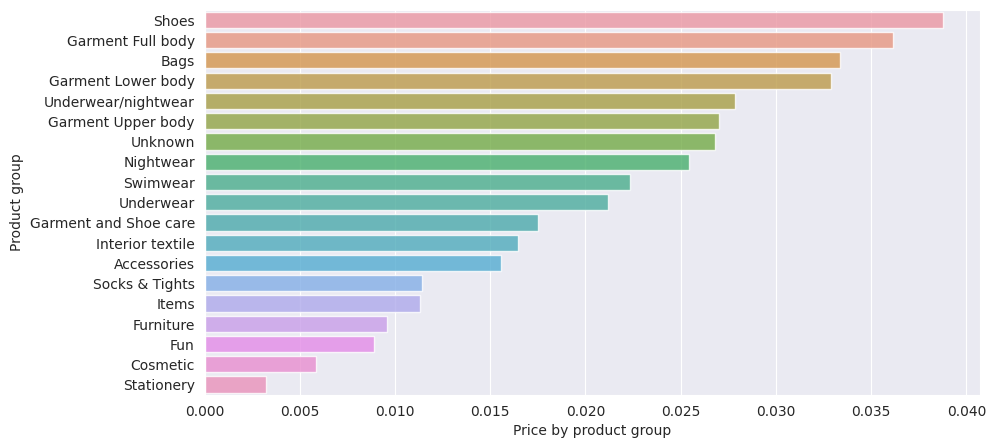

In [40]:
articles_index = mergd_df[['product_group_name', 'price']].groupby('product_group_name').mean().sort_values(by='price', ascending=False)
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=articles_index.price, y=articles_index.index, alpha=0.8)
ax.set_xlabel('Price by product group')
ax.set_ylabel('Product group')
plt.show()

* Mean price change in time for top 5 product groups

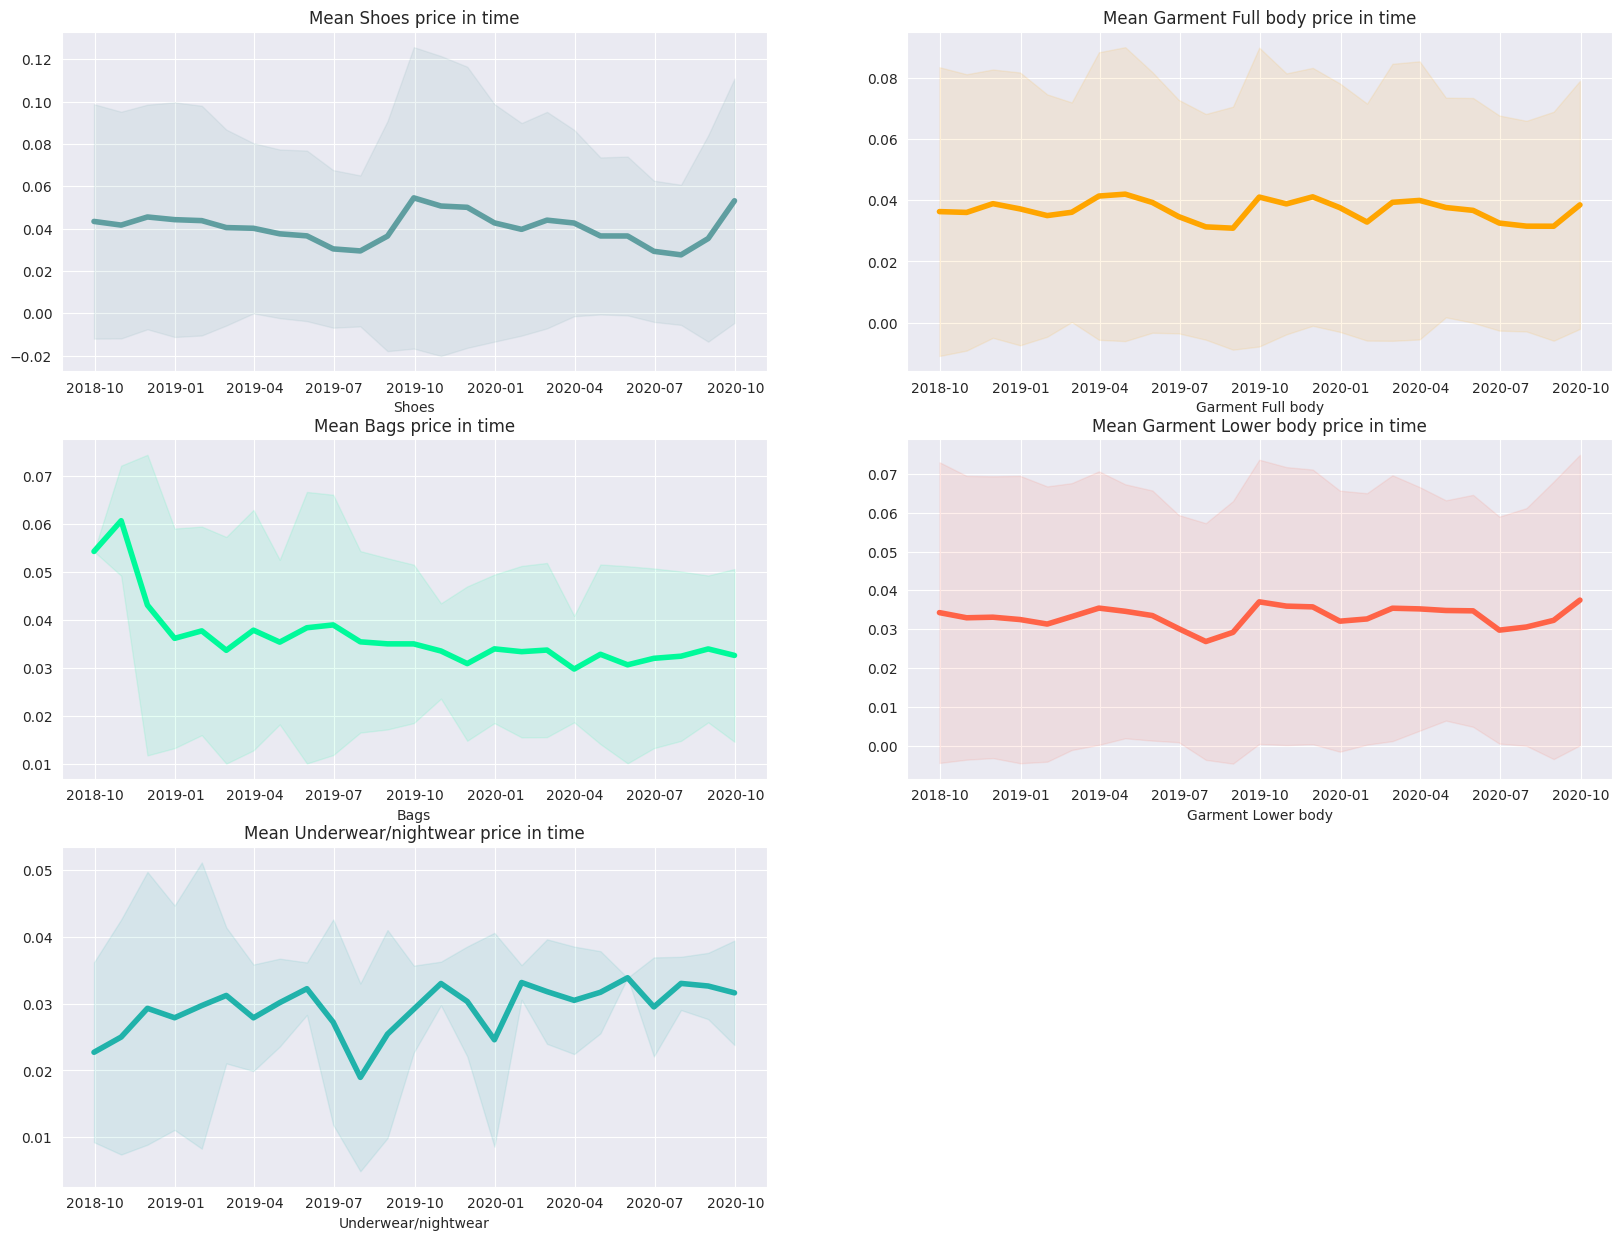

In [43]:
mergd_df['t_dat'] = pd.to_datetime(mergd_df['t_dat'])

product_list = ['Shoes', 'Garment Full body', 'Bags', 'Garment Lower body', 'Underwear/nightwear']
colors = ['cadetblue', 'orange', 'mediumspringgreen', 'tomato', 'lightseagreen']

k = 0
f, ax = plt.subplots(3, 2, figsize=(20, 15))
for i in range(3):
    for j in range(2):
        try:
            product = product_list[k]
            articles_for_merge_product = mergd_df[mergd_df.product_group_name == product_list[k]]
            series_mean = articles_for_merge_product[['t_dat', 'price']].groupby(pd.Grouper(key="t_dat", freq='M')).mean().fillna(0)
            series_std = articles_for_merge_product[['t_dat', 'price']].groupby(pd.Grouper(key="t_dat", freq='M')).std().fillna(0)
            ax[i, j].plot(series_mean, linewidth=4, color=colors[k])
            ax[i, j].fill_between(series_mean.index, (series_mean.values-2*series_std.values).ravel(), 
                             (series_mean.values+2*series_std.values).ravel(), color=colors[k], alpha=.1)
            ax[i, j].set_title(f'Mean {product_list[k]} price in time')
            ax[i, j].set_xlabel('month')
            ax[i, j].set_xlabel(f'{product_list[k]}')
            k += 1
        except IndexError:
            ax[i, j].set_visible(False)
plt.show()